IMPORTING ALL RELEVANT LIBRARIES

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack
from google.colab import drive

LOADING DATASET AND TRAINING SET FILES

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/ML/train.csv")
test=pd.read_csv("/content/drive/MyDrive/ML/test.csv")

REMOVING INVALID ENTRIES

In [ ]:
dataset=dataset[dataset["PRODUCT_PRICE"]>0]

PRELIMINARY DATA ANALYSIS

In [ ]:
print(len(dataset))
print(len(dataset.columns))

1259414
8


In [ ]:
dataset.head()

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_CONDITION,CATEGORY,PRODUCT_BRAND,SHIPPING_AVAILABILITY,PRODUCT_DESCRIPTION,PRODUCT_PRICE
0,952289,Lipstick queen reserved maiwu,4,Beauty/Makeup/Lips,NaN,0,Lipstick Queen Jean Queen and medieval lipstic...,20.0
1,121903,Garbage Pail Kids blu ray,3,Electronics/Media/Blu-Ray,NaN,1,26Plays great. Tested. Watched once. No scratc...,15.0
2,280534,green floam/slime,1,Kids/Toys/Arts & Crafts,NaN,0,"-6 oz, dragon fruit scented - KEEP OUT OF REAC...",8.0
3,787961,Wallet beige monogram,1,Women/Women's Accessories/Wallets,NaN,0,Wallet brand new never used,31.0
4,479292,Triangle Bike Or Body Blue Light,3,Sports & Outdoors/Outdoors/Other,NaN,0,"Triangle Bike Or Body Blue Light, steady or fl...",8.0


In [ ]:
print(test.isna().sum())

PRODUCT_ID                   0
PRODUCT_NAME                 0
PRODUCT_CONDITION            0
CATEGORY                   911
PRODUCT_BRAND            94797
SHIPPING_AVAILABILITY        0
PRODUCT_DESCRIPTION          1
dtype: int64


The rows with null values at the Product description column will be dropped. The null values in Category and Product Brand will be replaced by "Unbranded" and "Uncategorized" respectively. 

In [ ]:
dataset.describe()

,PRODUCT_ID,PRODUCT_CONDITION,SHIPPING_AVAILABILITY,PRODUCT_PRICE
count,1.259414e+06,1.259414e+06,1.259414e+06,1.259414e+06
mean,7.408659e+05,1.907433e+00,4.472882e-01,2.673618e+01
std,4.280122e+05,9.032646e-01,4.972139e-01,3.856483e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00
25%,3.698902e+05,1.000000e+00,0.000000e+00,1.000000e+01
50%,7.408380e+05,2.000000e+00,0.000000e+00,1.700000e+01
75%,1.111328e+06,3.000000e+00,1.000000e+00,2.900000e+01
max,1.482534e+06,5.000000e+00,1.000000e+00,2.009000e+03


In [ ]:
print(dataset.isna().sum())
print(test.isna().sum())

PRODUCT_ID                    0
PRODUCT_NAME                  0
PRODUCT_CONDITION             0
CATEGORY                   5407
PRODUCT_BRAND            537588
SHIPPING_AVAILABILITY         0
PRODUCT_DESCRIPTION           3
PRODUCT_PRICE                 0
dtype: int64
PRODUCT_ID                   0
PRODUCT_NAME                 0
PRODUCT_CONDITION            0
CATEGORY                   911
PRODUCT_BRAND            94797
SHIPPING_AVAILABILITY        0
PRODUCT_DESCRIPTION          1
dtype: int64


ELEMENTARY PRE-PROCESSING

In [ ]:
dataset.drop(axis="rows", labels=dataset.index[dataset["PRODUCT_DESCRIPTION"].isna()], inplace=True)
test["PRODUCT_DESCRIPTION"].fillna("Null",inplace=True)
dataset["PRODUCT_BRAND"].fillna("Unbranded", inplace=True)
test["PRODUCT_BRAND"].fillna("Unbranded", inplace=True)
dataset["CATEGORY"].fillna("Uncategorized", inplace=True)
test["CATEGORY"].fillna("Uncategorized", inplace=True)

EXPLORATORY DATA ANALYSIS OF PRODUCT_NAME

In [ ]:
dataset["PRODUCT_NAME"].describe()

count     1259411
unique    1051903
top        Bundle
freq         1873
Name: PRODUCT_NAME, dtype: object

In [ ]:
dataset["PRODUCT_NAME"].value_counts()[:20]

Bundle                  1873
Reserved                 391
Converse                 376
BUNDLE                   358
Dress                    349
Lularoe TC leggings      336
Coach purse              331
Romper                   297
Nike                     287
Vans                     282
American Eagle Jeans     281
Lularoe OS leggings      246
Miss Me Jeans            243
ON HOLD                  237
Coach Purse              211
Shorts                   210
Lularoe Irma             207
Coach wallet             204
Bundle!                  203
Miss me jeans            199
Name: PRODUCT_NAME, dtype: int64

The Product Name "Bundle" appears most commonly. On top of this, it occurs three times in different forms- "Bundle", "BUNDLE", and "Bundle!". Special characters and upper/lower case disputes will be taken care of in pre-processing.

EXPLORATORY DATA ANALYSIS OF PRODUCT_CONDITION

In [ ]:
dataset["PRODUCT_CONDITION"].describe()

count    1.259411e+06
mean     1.907429e+00
std      9.032613e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: PRODUCT_CONDITION, dtype: float64

In [ ]:
dataset["PRODUCT_CONDITION"].value_counts()[:20]

1    544269
3    367379
2    318621
4     27121
5      2021
Name: PRODUCT_CONDITION, dtype: int64

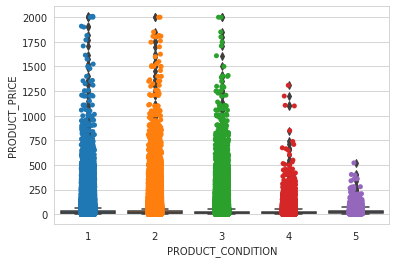

In [ ]:
sns.set_style('whitegrid')
sns.boxplot(x='PRODUCT_CONDITION',y='PRODUCT_PRICE',data=dataset)
sns.stripplot(x='PRODUCT_CONDITION',y='PRODUCT_PRICE',data=dataset)

In [ ]:
for i in range(1,6):
  print("Product Condition",i,"Median Price: ",dataset[dataset["PRODUCT_CONDITION"]==i]["PRODUCT_PRICE"].median())

Product Condition 1 Median Price:  18.0
Product Condition 2 Median Price:  17.0
Product Condition 3 Median Price:  16.0
Product Condition 4 Median Price:  15.0
Product Condition 5 Median Price:  19.0


The above boxplot shows the product prices for products falling under product conditions 1-5. The median of the prices decrease from product conditions 1-4, after which there is a sharp increase in the median of the prices for product condition 5.

EXPLORATORY DATA ANALYSIS FOR CATEGORY

In [ ]:
dataset["CATEGORY"].describe()

count                                            1259411
unique                                              1276
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               51181
Name: CATEGORY, dtype: object

In [ ]:
dataset["CATEGORY"].value_counts()[:20]

Women/Athletic Apparel/Pants, Tights, Leggings                 51181
Women/Tops & Blouses/T-Shirts                                  39358
Beauty/Makeup/Face                                             29091
Beauty/Makeup/Lips                                             25455
Electronics/Video Games & Consoles/Games                       22420
Beauty/Makeup/Eyes                                             21460
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    20951
Women/Underwear/Bras                                           18080
Women/Tops & Blouses/Tank, Cami                                17264
Women/Tops & Blouses/Blouse                                    17167
Women/Dresses/Above Knee, Mini                                 17073
Women/Jewelry/Necklaces                                        16849
Women/Athletic Apparel/Shorts                                  16510
Beauty/Makeup/Makeup Palettes                                  16167
Women/Shoes/Boots                 

Since element in the category column consists of three categories(each separated by a slash), we can separate them into three different columns. 

In [ ]:
category_split1=[]
category_split2=[]
category_split3=[]
for i in dataset["CATEGORY"]:
    sample = str(i)
    value = i.split("/")
    if len(value)>=1:
      category_split1.append(value[0])
    else:
      category_split1.append('Uncategorized')
    if len(value)>=2:
      category_split2.append(value[1])
    else:
      category_split2.append('Uncategorized')
    if len(value)>=3:
      category_split3.append(value[2])
    else:
      category_split3.append('Uncategorized')

In [ ]:
print(type(dataset['CATEGORY']))
dataset['CATEGORY1'] = category_split1
dataset['CATEGORY2'] = category_split2
dataset['CATEGORY3'] = category_split3

print(len(category_split1))
print(dataset.shape)
dataset.head()

<class 'pandas.core.series.Series'>
1259411
(1259411, 11)


,PRODUCT_ID,PRODUCT_NAME,PRODUCT_CONDITION,CATEGORY,PRODUCT_BRAND,SHIPPING_AVAILABILITY,PRODUCT_DESCRIPTION,PRODUCT_PRICE,CATEGORY1,CATEGORY2,CATEGORY3
0,952289,Lipstick queen reserved maiwu,4,Beauty/Makeup/Lips,Unbranded,0,Lipstick Queen Jean Queen and medieval lipstic...,20.0,Beauty,Makeup,Lips
1,121903,Garbage Pail Kids blu ray,3,Electronics/Media/Blu-Ray,Unbranded,1,26Plays great. Tested. Watched once. No scratc...,15.0,Electronics,Media,Blu-Ray
2,280534,green floam/slime,1,Kids/Toys/Arts & Crafts,Unbranded,0,"-6 oz, dragon fruit scented - KEEP OUT OF REAC...",8.0,Kids,Toys,Arts & Crafts
3,787961,Wallet beige monogram,1,Women/Women's Accessories/Wallets,Unbranded,0,Wallet brand new never used,31.0,Women,Women's Accessories,Wallets
4,479292,Triangle Bike Or Body Blue Light,3,Sports & Outdoors/Outdoors/Other,Unbranded,0,"Triangle Bike Or Body Blue Light, steady or fl...",8.0,Sports & Outdoors,Outdoors,Other


In [ ]:
category_split1=[]
category_split2=[]
category_split3=[]
for i in test["CATEGORY"]:
    sample = str(i)
    value = i.split("/")
    if len(value)>=1:
      category_split1.append(value[0])
    else:
      category_split1.append('Uncategorized')
    if len(value)>=2:
      category_split2.append(value[1])
    else:
      category_split2.append('Uncategorized')
    if len(value)>=3:
      category_split3.append(value[2])
    else:
      category_split3.append('Uncategorized')

In [ ]:

test['CATEGORY1'] = category_split1
test['CATEGORY2'] = category_split2
test['CATEGORY3'] = category_split3




EXPLORATORY DATA ANALYSIS FOR PRODUCT_BRAND

In [ ]:
dataset["PRODUCT_BRAND"].describe()

count       1259411
unique         4630
top       Unbranded
freq         537586
Name: PRODUCT_BRAND, dtype: object

In [ ]:
dataset["PRODUCT_BRAND"].value_counts()[:20]

Unbranded            537586
Nike                  46008
PINK                  45934
Victoria's Secret     40805
LuLaRoe               26347
Apple                 14669
FOREVER 21            12898
Nintendo              12680
Lululemon             12318
Michael Kors          11814
American Eagle        11328
Rae Dunn              10415
Sephora               10401
Coach                  8906
Disney                 8846
Bath & Body Works      8796
Adidas                 8695
Funko                  7803
Under Armour           7190
Sony                   6761
Name: PRODUCT_BRAND, dtype: int64

Since there almost half of the brand entries in this dataset are "Unbranded", we will try to infer the brand of the product from the product description. 

EXPLORATORY DATA ANALYSIS FOR SHIPPING_AVAILABILITY

In [ ]:
dataset["SHIPPING_AVAILABILITY"].describe()

count    1.259411e+06
mean     4.472892e-01
std      4.972140e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: SHIPPING_AVAILABILITY, dtype: float64

In [ ]:
dataset["SHIPPING_AVAILABILITY"].value_counts()[:20]

0    696090
1    563321
Name: SHIPPING_AVAILABILITY, dtype: int64

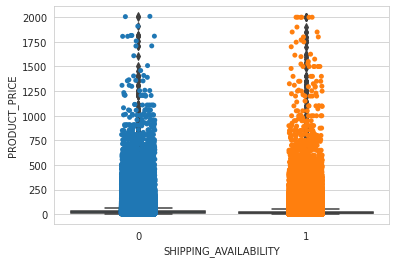

In [ ]:
sns.set_style('whitegrid')
sns.boxplot(x='SHIPPING_AVAILABILITY',y='PRODUCT_PRICE',data=dataset)
sns.stripplot(x='SHIPPING_AVAILABILITY',y='PRODUCT_PRICE',data=dataset)

In [ ]:
print("Shipping Availability",0,"Median Price: ",dataset[dataset["SHIPPING_AVAILABILITY"]==0]["PRODUCT_PRICE"].median())
print("Shipping Availability",1,"Median Price: ",dataset[dataset["SHIPPING_AVAILABILITY"]==1]["PRODUCT_PRICE"].median())

Shipping Availability 0 Median Price:  20.0
Shipping Availability 1 Median Price:  14.0


The median price for items that are not available for shipping is higher that the median price for items that are available for shipping. 

PRE-PROCESSING FOR PRODUCT_NAME

All special characters and punctuation marks are removed from the name and description columns. 

In [ ]:
product_name=[]
for i in dataset["PRODUCT_NAME"]:
  name = re.sub('[^A-Za-z0-9]+', ' ', i)
  product_name.append(name.lower())

dataset["PRODUCT_NAME"]=product_name

product_desc=[]

for i in dataset["PRODUCT_DESCRIPTION"]:
  desc = re.sub('[^A-Za-z0-9]+', ' ', i)
  product_desc.append(desc.lower().strip())

dataset["PRODUCT_DESCRIPTION"]=product_desc

#dataset["PRODUCT_NAME"].value_counts()[:20]

In [ ]:
product_name=[]
for i in test["PRODUCT_NAME"]:
  name = re.sub('[^A-Za-z0-9]+', ' ', i)
  product_name.append(name.lower())

test["PRODUCT_NAME"]=product_name

product_desc=[]

for i in test["PRODUCT_DESCRIPTION"]:
  
  desc = re.sub('[^A-Za-z0-9]+', ' ', i)
  product_desc.append(desc.lower().strip())

test["PRODUCT_DESCRIPTION"]=product_desc


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
product_desc=dataset["PRODUCT_DESCRIPTION"]
new_product_desc=[]
for desc in product_desc:
  new_product_desc.append(remove_stopwords(desc))
dataset["PRODUCT_DESCRIPTION"]=new_product_desc

In [ ]:
product_desc=test["PRODUCT_DESCRIPTION"]
new_product_desc=[]
for desc in product_desc:
  new_product_desc.append(remove_stopwords(desc))
test["PRODUCT_DESCRIPTION"]=new_product_desc

In [ ]:
dataset["PRODUCT_NAME"].value_counts()[:20]

bundle                  2332
lularoe tc leggings      954
lularoe os leggings      772
miss me jeans            573
coach purse              571
american eagle jeans     564
reserved                 562
on hold                  485
michael kors purse       468
bundle                   459
michael kors wallet      409
converse                 404
coach wallet             379
lularoe irma             371
dress                    363
nike shorts              343
lularoe leggings         335
coach wristlet           333
vans                     321
reserved bundle          321
Name: PRODUCT_NAME, dtype: int64

The following code checks if the product description column corresponding to Unbranded products contains any of the brand names present in the brand column. If it does, "Unbranded" is replaced with that brand name. 

In [ ]:
updatedbrands=[]
brands = dataset['PRODUCT_BRAND'].unique()
brands=list(brands)
brands.remove('Unbranded')
for row in dataset.itertuples():
  flag=False
  if str(row.PRODUCT_BRAND) == 'Unbranded':
    for brand in brands:
      if str(brand) in str(row.PRODUCT_DESCRIPTION):
        flag=True
        updatedbrands.append(str(brand))
        break
    if flag==False:
      updatedbrands.append('Unbranded')
  else:
    updatedbrands.append(str(row.PRODUCT_BRAND))

dataset["PRODUCT_BRAND"]=updatedbrands

In [ ]:
updatedbrands=[]
brands = test['PRODUCT_BRAND'].unique()
brands=list(brands)
brands.remove('Unbranded')
for row in test.itertuples():
  flag=False
  if str(row.PRODUCT_BRAND) == 'Unbranded':
    for brand in brands:
      if str(brand) in str(row.PRODUCT_DESCRIPTION):
        flag=True
        updatedbrands.append(str(brand))
        break
    if flag==False:
      updatedbrands.append('Unbranded')
  else:
    updatedbrands.append(str(row.PRODUCT_BRAND))

test["PRODUCT_BRAND"]=updatedbrands

VECTORIZATION and LABEL_BINARIZER

The following code vectorizes the name and description column and label binarizes the other columns. The vectorization process maps a string to about 100000 columns of numerical data, each column consisting of a value between 0 and 1. The Binarization process is an efficient form of pure one hot encoding, where 1 column value corresponding to a row has a value of 1 and all other columns have a value of 0. 

---



In [ ]:
def vectorize_column(column, vectorizer):
    if vectorizer==None:
      vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
      vectorizer.fit(column)
    transformed_column = vectorizer.transform(column)
    return transformed_column, vectorizer

In [ ]:

x_train = dataset
#x_train=dataset.to_numpy().astype(np.float64)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb_item_condition_id = LabelBinarizer(sparse_output=True)
productcondition = lb_item_condition_id.fit_transform(x_train['PRODUCT_CONDITION'])

lb_shipping = LabelBinarizer(sparse_output=True)
shippingavailability = lb_shipping.fit_transform(x_train['SHIPPING_AVAILABILITY'])

lb_cat1 = LabelBinarizer(sparse_output=True)
cat1 = lb_cat1.fit_transform(x_train['CATEGORY1'])

lb_cat2 = LabelBinarizer(sparse_output=True)
cat2 = lb_cat2.fit_transform(x_train['CATEGORY2'])

lb_cat3 = LabelBinarizer(sparse_output=True)
cat3 = lb_cat3.fit_transform(x_train['CATEGORY3'])

lb_brand= LabelBinarizer(sparse_output=True)
brand = lb_brand.fit_transform(x_train['PRODUCT_BRAND'])

name, nametemp = vectorize_column(x_train['PRODUCT_NAME'], None)
desc, desctemp = vectorize_column(x_train['PRODUCT_DESCRIPTION'], None)


In [ ]:

x_train_final = hstack((cat1, cat2, cat3, brand, name, desc, productcondition, shippingavailability)).tocsr()

In [ ]:
x_test = test

In [ ]:
shippingavailability = lb_shipping.transform(x_test['SHIPPING_AVAILABILITY'])
productcondition = lb_item_condition_id.transform(x_test['PRODUCT_CONDITION'])
cat1 = lb_cat1.transform(x_test['CATEGORY1'])
cat2 = lb_cat2.transform(x_test['CATEGORY2'])
cat3 = lb_cat3.transform(x_test['CATEGORY3'])
brand = lb_brand.transform(x_test['PRODUCT_BRAND'])

name, nametemp1 = vectorize_column(x_test['PRODUCT_NAME'], nametemp)
desc, desctemp1 = vectorize_column(x_test['PRODUCT_DESCRIPTION'], desctemp)

In [ ]:
x_test_final = hstack((cat1, cat2, cat3, brand, name, desc, productcondition, shippingavailability)).tocsr()

The following is a neural networks model with a batch size of 2048 and 5 hidden layers. Many combinations of layers and neurons were tested out. The following gave us the best MSLE.  

In [ ]:
import keras
from keras import backend, optimizers, callbacks
from keras.models import Model
from keras.layers import Input, Dense
def nn_model(X, y):
    
    model_in = Input(shape = (X.shape[1],), dtype = 'float32', sparse = True)
    out=Dense(1024, activation='relu')(model_in)
    out=Dense(512, activation='relu')(out)
    out=Dense(256, activation='relu')(out)
    out=Dense(128, activation='relu')(out)
    out=Dense(64, activation='relu')(out)

    model_out=Dense(1)(out)    
    model = Model(model_in, model_out)    
    model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(3e-3))   
    model.fit(X, y, batch_size = 2048, epochs = 1, verbose = 1)
    
    return model

In [ ]:
x_train_final

<1259411x205625 sparse matrix of type '<class 'numpy.float64'>'
	with 42271957 stored elements in Compressed Sparse Row format>

In [ ]:
x_test_final

<222381x205625 sparse matrix of type '<class 'numpy.float64'>'
	with 7433938 stored elements in Compressed Sparse Row format>

If product price is p, the model predicts the **variance of log(p+1)**. 




In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(np.log1p(dataset['PRODUCT_PRICE'].values.reshape(-1, 1)))


In [ ]:
model = nn_model(x_train_final, y_train)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


615/615 [==============================] - 1673s 3s/step - loss: 0.3619


The predicted values are scaled back up and inversed [exp(y_pred)-1]. 

In [ ]:
y_pred = model.predict(x_test_final)
y_pred=np.expm1(scaler.inverse_transform(y_pred.reshape(-1, 1)))

6950/6950 [==============================] - 66s 9ms/step


In [ ]:
submission=pd.read_csv("/content/drive/MyDrive/ML/submission.csv")["PRODUCT_ID"]
submission=pd.concat([submission,pd.DataFrame(y_pred)],axis=1)
submission.to_csv('/content/drive/MyDrive/ML/submission7.csv')